In [4]:
from model_xray.zenml.pipelines.data_creation.data_classes import ModelRepos
from model_xray.zenml.pipelines.data_creation.model_attack import embed_payload_into_pretrained_weights_pipeline
from model_xray.config_classes import EmbedPayloadConfig, EmbedType, GrayscaleLastMBytesConfig, ImageRepConfig, ImageType, PayloadType, XLSBAttackConfig
from model_xray.utils.image_rep_utils import image_rep_map

from model_xray.zenml.pipelines.data_creation.image_representation import image_representation_from_attacked_pretrained_pipeline


pretrained_model_name = "MobileNet"
pretrained_model_repo = ModelRepos.KERAS

embedding_config = EmbedPayloadConfig(
    embed_type=EmbedType.X_LSB_ATTACK_FILL,
    embed_proc_config=XLSBAttackConfig(
        x=8,
        fill=True,
        msb=False,
        payload_type=PayloadType.RANDOM,
    )
)

res = image_representation_from_attacked_pretrained_pipeline(
    pretrained_model_name=pretrained_model_name,
    pretrained_model_repo=pretrained_model_repo,
    embed_payload_config=embedding_config,
    image_rep_config=ImageRepConfig(
        image_type=ImageType.GRAYSCALE_LAST_M_BYTES,
        image_rep_config=GrayscaleLastMBytesConfig(m=4)
    )
)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱  1 from model_xray.zenml.pipelines.data_creation.data_classes import ModelRepos                │
│    2 from model_xray.zenml.pipelines.data_creation.model_attack import embed_payload_into_pre    │
│    3 from model_xray.config_classes import EmbedPayloadConfig, EmbedType, GrayscaleLastMBytes    │
│    4 from model_xray.utils.image_rep_utils import image_rep_map                                  │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ImportError: cannot import name 'ModelRepos' from 'model_xray.zenml.pipelines.data_creation.data_classes' 
(/home/danielg/danigil/ModelXRay/model_xray/zenml/pipelines/data_creation/data_classes.py)

In [ ]:
# res.steps.keys()
im = res.steps["create_image_representation"].output.load()
im.shape
# im = 

(1, 4126, 4126)

In [ ]:
from model_xray.config_classes import ClassificationMetricConfig, DatasetConfig
from model_xray.zenml.pipelines.model_evaluation.eval_model import evaluate_pretrained_model

from model_xray.config_classes import ClassificationMetric, ClassificationMetricConfig, DatasetConfig, DatasetType, EmbedPayloadConfig, ImageDatasetConfig, ModelRepos

results = {}

for x in range(0, 24, 3):
    response = evaluate_pretrained_model(
        model_repo=ModelRepos.KERAS,
        pretrained_model_name='MobileNet',

        ds_name='imagenet12',
        ds_config=DatasetConfig.ret_img_ds_config(image_size=(224, 224), take=100),

        requested_metrics=[
            ClassificationMetricConfig.ret_top_k_categorical_accuracy_config(k=1),
        ],
        embed_payload_config=EmbedPayloadConfig.ret_x_lsb_attack_fill_config(x=x) if x > 0 else None
    )

    results[x] = response.steps["calc_metrics"].output.load()

2024-08-17 18:30:03.446869: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-17 18:30:03.469402: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-17 18:30:03.469418: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-17 18:30:03.469433: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-17 18:30:03.473694: I tensorflow/core/platform/cpu_feature_g

PyTorch version 2.4.0+cu118 available.
TensorFlow version 2.14.0 available.
Initiating a new run for the pipeline: evaluate_pretrained_model.
Executing a new run.
Using user: default
Using stack: custom-stack
  experiment_tracker: mlflow_experiment_tracker
  orchestrator: default
  artifact_store: custom_artifact_store_local
Dashboard URL: http://127.0.0.1:8237/runs/40ab2180-d47d-4d11-9776-a96218bb9294
Caching enabled explicitly for fetch_pretrained.
Using cached version of fetch_pretrained.
Step fetch_pretrained has started.
Using cached version of get_val_ds.
Step get_val_ds has started.
Using cached version of eval_model.
Step eval_model has started.
Using cached version of extract_y_true.
Step extract_y_true has started.
Using cached version of calc_metrics.
Step calc_metrics has started.
Pipeline run has finished in 2.093s.
Starting embedding random payload into MobileNet pretrained weights using x_lsb_attack_fill embedding with x=3
Initiating a new run for the pipeline: evaluate_

In [ ]:
accs = [v[ClassificationMetricConfig.ret_top_k_categorical_accuracy_config(k=1)] for k,v in results.items()]
print(results.keys())
accs

dict_keys([0, 3, 6, 9, 12, 15, 18, 21])


[0.69625,
 0.69625,
 0.69625,
 0.6965625,
 0.6953125,
 0.6978125,
 0.6859375,
 0.0034375]

In [ ]:
import numpy as np

from model_xray.zenml.pipelines.data_creation.fetch_pretrained import fetch_pretrained_model_and_extract_weights
from model_xray.config_classes import ModelRepos
from model_xray.zenml.pipelines.data_creation.model_attack import embed_payload_into_pretrained_weights_pipeline

model_repo=ModelRepos.KERAS
pretrained_model_name = 'MobileNet'

unmodified_weights_reponse = fetch_pretrained_model_and_extract_weights(
    model_repo=model_repo,
    pretrained_model_name=pretrained_model_name
)

unmodified_weights = np.array([unmodified_weights_reponse.steps["extract_weights"].output.load()])

print(unmodified_weights.shape)

eq_amounts = {}

for i in range(0, 24, 3):
    if i == 1:
        continue
    ew_response = embed_payload_into_pretrained_weights_pipeline(
        pretrained_model_repo=model_repo,
        pretrained_model_name=pretrained_model_name,
        embed_payload_config=EmbedPayloadConfig.ret_x_lsb_attack_fill_config(x=i)
    )

    modified_weights = np.array([ew_response.steps["embed_payload_into_weights"].output.load()])

    eq_true = np.equal(unmodified_weights, modified_weights) == True
    eq_amounts[i] = np.count_nonzero(eq_true, axis=1)

Initiating a new run for the pipeline: fetch_pretrained_model_and_extract_weights.
Executing a new run.
Using user: default
Using stack: custom-stack
  experiment_tracker: mlflow_experiment_tracker
  orchestrator: default
  artifact_store: custom_artifact_store_local
Dashboard URL: http://127.0.0.1:8237/runs/e9ed65d3-91e6-4f67-8d19-775b1efa4cad
Caching enabled explicitly for fetch_pretrained.
Using cached version of fetch_pretrained.
Step fetch_pretrained has started.
Caching enabled explicitly for extract_weights.
Using cached version of extract_weights.
Step extract_weights has started.
Pipeline run has finished in 1.128s.
(1, 4253864)
Starting embedding random payload into MobileNet pretrained weights using x_lsb_attack_fill embedding with x=1
Initiating a new run for the pipeline: embed_payload_into_pretrained_weights_pipeline.
Executing a new run.
Using user: default
Using stack: custom-stack
  experiment_tracker: mlflow_experiment_tracker
  orchestrator: default
  artifact_store:

In [ ]:
for i in range(1, 24, 3):
    print(f'\tLSB {i}: min: {np.min(eq_amounts[i])}, max: {np.max(eq_amounts[i])}, mean: {np.mean(eq_amounts[i])}')

	LSB 1: min: 2126529, max: 2126529, mean: 2126529.0
	LSB 2: min: 1062044, max: 1062044, mean: 1062044.0
	LSB 3: min: 531524, max: 531524, mean: 531524.0
	LSB 4: min: 266456, max: 266456, mean: 266456.0
	LSB 5: min: 132637, max: 132637, mean: 132637.0
	LSB 6: min: 65960, max: 65960, mean: 65960.0
	LSB 7: min: 33416, max: 33416, mean: 33416.0
	LSB 8: min: 16702, max: 16702, mean: 16702.0
	LSB 9: min: 8267, max: 8267, mean: 8267.0
	LSB 10: min: 4118, max: 4118, mean: 4118.0
	LSB 11: min: 2056, max: 2056, mean: 2056.0
	LSB 12: min: 1020, max: 1020, mean: 1020.0
	LSB 13: min: 529, max: 529, mean: 529.0
	LSB 14: min: 295, max: 295, mean: 295.0
	LSB 15: min: 116, max: 116, mean: 116.0
	LSB 16: min: 76, max: 76, mean: 76.0
	LSB 17: min: 32, max: 32, mean: 32.0
	LSB 18: min: 13, max: 13, mean: 13.0
	LSB 19: min: 13, max: 13, mean: 13.0
	LSB 20: min: 4, max: 4, mean: 4.0
	LSB 21: min: 2, max: 2, mean: 2.0
	LSB 22: min: 1, max: 1, mean: 1.0
	LSB 23: min: 0, max: 0, mean: 0.0


In [ ]:
results[0][ClassificationMetricConfig.ret_top_k_categorical_accuracy_config(k=1)]

0.69625

In [ ]:
from model_xray.zenml.pipelines.data_creation.image_representation import image_representation_from_pretrained_pipeline, preprocessed_image_representation_from_pretrained_pipeline
import numpy as np

from model_xray.zenml.pipelines.data_creation.fetch_pretrained import fetch_pretrained_model_and_extract_weights
from model_xray.config_classes import *
from model_xray.zenml.pipelines.data_creation.model_attack import embed_payload_into_pretrained_weights_pipeline

pretrained_model_name = "InceptionResNetV2"
pretrained_model_repo = ModelRepos.KERAS

embedding_config = EmbedPayloadConfig(
    embed_type=EmbedType.X_LSB_ATTACK_FILL,
    embed_proc_config=XLSBAttackConfig(
        x=10,
        fill=True,
        msb=False,
        payload_type=PayloadType.RANDOM,
    )
)
preprocessed_image_representation_from_pretrained_pipeline(
    pretrained_model_name=pretrained_model_name,
    pretrained_model_repo=pretrained_model_repo,
    embed_payload_config = embedding_config,

    image_preprocess_config = ImagePreprocessConfig(
        image_size=(100, 100),
        image_reshape_algo=ImageResamplingFilter.BICUBIC
    ),

    image_rep_config = ImageRepConfig(
        image_type=ImageType.GRAYSCALE_FOURPART,
        image_rep_config=None
    )
)

# im_res = image_representation_from_pretrained_pipeline(
#     pretrained_model_name=pretrained_model_name,
#     pretrained_model_repo=pretrained_model_repo,
#     embed_payload_config=embedding_config,

#     image_rep_config=ImageRepConfig(
#         image_type=ImageType.GRAYSCALE_FOURPART,
#         image_rep_config=None
#     )
# )

# im = im_res.steps["create_image_representation"].output.load()
# im.shape

PyTorch version 2.4.0+cu118 available.
TensorFlow version 2.14.0 available.
Starting embedding random payload into InceptionResNetV2 pretrained weights using x_lsb_attack_fill embedding with x=10
Initiating a new run for the pipeline: _preprocessed_image_representation_from_pretrained_pipeline.
Registered new pipeline: _preprocessed_image_representation_from_pretrained_pipeline.
Executing a new run.
Using user: default
Using stack: custom-stack
  experiment_tracker: mlflow_experiment_tracker
  orchestrator: default
  artifact_store: custom_artifact_store_local
Dashboard URL: http://127.0.0.1:8237/runs/80b7286d-d3ca-4358-bad5-9c5f784bddc8
Caching enabled explicitly for fetch_pretrained.
Using cached version of fetch_pretrained.
Step fetch_pretrained has started.
Caching enabled explicitly for extract_weights.
Using cached version of extract_weights.
Step extract_weights has started.
Caching enabled explicitly for embed_payload_into_weights.
Step embed_payload_into_weights has started.
S

PipelineRunResponse(body=PipelineRunResponseBody(created=datetime.datetime(2024, 8, 17, 23, 22, 52, 133494), updated=datetime.datetime(2024, 8, 17, 23, 23, 3, 545451), user=UserResponse(body=UserResponseBody(created=datetime.datetime(2024, 8, 12, 13, 42, 5, 855431), updated=datetime.datetime(2024, 8, 12, 13, 44, 11, 417842), active=True, activation_token=None, full_name='', email_opted_in=False, is_service_account=False, is_admin=True), metadata=None, resources=None, id=UUID('876c07d3-fcbc-43d2-a146-06ba954a9dad'), permission_denied=False, name='default'), status=<ExecutionStatus.COMPLETED: 'completed'>, stack=StackResponse(body=StackResponseBody(created=datetime.datetime(2024, 8, 12, 14, 13, 3, 113442), updated=datetime.datetime(2024, 8, 12, 14, 13, 3, 113443), user=UserResponse(body=UserResponseBody(created=datetime.datetime(2024, 8, 12, 13, 42, 5, 855431), updated=datetime.datetime(2024, 8, 12, 13, 44, 11, 417842), active=True, activation_token=None, full_name='', email_opted_in=Fal

In [ ]:
from zenml.client import Client

artifact = Client().get_artifact_version('60968deb-6a43-40f4-aaa2-11b22f7cd81e')
# artifact = Client().get_artifact_version('2b0936d4-5e10-4c6b-b505-e7c0f724bd6d')
img = artifact.load()

img.shape

(100, 100)

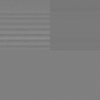

In [ ]:
from PIL import Image

Image.fromarray(img)

In [1]:
from model_xray.zenml.pipelines.data_creation.image_representation import image_representation_from_pretrained_pipeline, preprocessed_image_representation_from_pretrained_pipeline
import numpy as np

from model_xray.zenml.pipelines.data_creation.fetch_pretrained import fetch_pretrained_model_and_extract_weights
from model_xray.config_classes import *
from model_xray.zenml.pipelines.data_creation.model_attack import embed_payload_into_pretrained_weights_pipeline

preprocessed_image_representation_from_pretrained_pipeline(
    pretrained_model_config = PretrainedModelConfig(
        repo=ModelRepos.KERAS,
        name='MobileNetV2',
    ),

    image_rep_config=ImageRepConfig(
        image_type=ImageType.GRAYSCALE_FOURPART,
        image_rep_config=None
    ),

    image_preprocess_config=ImagePreprocessConfig(),

    embed_payload_config=EmbedPayloadConfig.ret_x_lsb_attack_fill_config(x=8)
)

PyTorch version 2.4.0+cu118 available.
TensorFlow version 2.14.0 available.
Starting embedding random payload into MobileNetV2 pretrained weights using x_lsb_attack_fill embedding with x=8
Initiating a new run for the pipeline: _preprocessed_image_representation_from_pretrained_pipeline.
Executing a new run.
Using user: default
Using stack: custom-stack
  artifact_store: custom_local
  experiment_tracker: mlflow_experiment_tracker
  orchestrator: default
Dashboard URL: http://127.0.0.1:8237/runs/0ec507ec-d3d2-4d64-8356-364671008112
Caching enabled explicitly for fetch_pretrained.
Using cached version of fetch_pretrained.
Step fetch_pretrained has started.
Caching enabled explicitly for extract_weights.
Using cached version of extract_weights.
Step extract_weights has started.
Caching enabled explicitly for embed_payload_into_weights.
Using cached version of embed_payload_into_weights.
Step embed_payload_into_weights has started.
Caching enabled explicitly for create_image_representatio

PipelineRunResponse(body=PipelineRunResponseBody(created=datetime.datetime(2024, 8, 19, 12, 7, 55, 150688), updated=datetime.datetime(2024, 8, 19, 12, 7, 59, 293161), user=UserResponse(body=UserResponseBody(created=datetime.datetime(2024, 8, 17, 23, 59, 37, 668468), updated=datetime.datetime(2024, 8, 18, 0, 2, 49, 626363), active=True, activation_token=None, full_name='', email_opted_in=False, is_service_account=False, is_admin=True), metadata=None, resources=None, id=UUID('8c66513b-5e16-4bbf-a271-7b389d6c1d2d'), permission_denied=False, name='default'), status=<ExecutionStatus.COMPLETED: 'completed'>, stack=StackResponse(body=StackResponseBody(created=datetime.datetime(2024, 8, 18, 0, 9, 44, 367644), updated=datetime.datetime(2024, 8, 18, 14, 0, 2, 656046), user=UserResponse(body=UserResponseBody(created=datetime.datetime(2024, 8, 17, 23, 59, 37, 668468), updated=datetime.datetime(2024, 8, 18, 0, 2, 49, 626363), active=True, activation_token=None, full_name='', email_opted_in=False, i

In [2]:
from zenml import step
from zenml.client import Client
from zenml.enums import ModelStages

model = Client().get_model_version(
    model_name_or_id="model_pretrained",
)

In [ ]:
model.run_metadata[''].keys()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 model.run_metadata[''].keys()                                                                │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: ''

In [ ]:
model.data_artifacts.keys()

dict_keys(['fetched_pretrained_model', 'extracted_weights', 'embedded_weights', 'image_representation', 'image_preprocessed'])

In [ ]:
model.pipeline_runs.values()

dict_values([PipelineRunResponse(body=PipelineRunResponseBody(created=datetime.datetime(2024, 8, 17, 23, 4, 39, 615716), updated=datetime.datetime(2024, 8, 17, 23, 4, 44, 254873), user=UserResponse(body=UserResponseBody(created=datetime.datetime(2024, 8, 12, 13, 42, 5, 855431), updated=datetime.datetime(2024, 8, 12, 13, 44, 11, 417842), active=True, activation_token=None, full_name='', email_opted_in=False, is_service_account=False, is_admin=True), metadata=None, resources=None, id=UUID('876c07d3-fcbc-43d2-a146-06ba954a9dad'), permission_denied=False, name='default'), status=<ExecutionStatus.COMPLETED: 'completed'>, stack=StackResponse(body=StackResponseBody(created=datetime.datetime(2024, 8, 12, 14, 13, 3, 113442), updated=datetime.datetime(2024, 8, 12, 14, 13, 3, 113443), user=UserResponse(body=UserResponseBody(created=datetime.datetime(2024, 8, 12, 13, 42, 5, 855431), updated=datetime.datetime(2024, 8, 12, 13, 44, 11, 417842), active=True, activation_token=None, full_name='', email_

In [3]:
def get_metadata_values(keys=['pretrained_model_config', 'image_rep_config', 'image_preprocess_config', 'embed_payload_config',]):
    ret = {}

    for pipeline_run_name, pipeline_run_reponse in model.pipeline_runs.items():
        ret[pipeline_run_name] = {}
        curr_steps = pipeline_run_reponse.steps

        for step_name, step_response in curr_steps.items():
            curr_step_metadata = step_response.output.run_metadata
            
            for key in keys:
                if key in curr_step_metadata:
                    ret[pipeline_run_name][key] = curr_step_metadata[key].value

    return ret


# for pipeline_run_name, pipeline_run_reponse in model.pipeline_runs.items():
#     print(pipeline_run_name)
#     # print(pipeline_run_reponse.artifact_versions)
#     curr_steps = pipeline_run_reponse.steps

#     for step_name, step_response in curr_steps.items():
#         curr_step_metadata = step_response.output.run_metadata
#         if step_name == "embed_payload_into_weights":

#             embedding_properties = curr_step_metadata['embedding_properties']
#             print('embedding_properties: \n', embedding_properties.value)
#             embedding_config = curr_step_metadata['embedding_config']
#             print('embedding_config: \n',embedding_config.value)

#         print(f'\t{step_name}')
#         print('\t', step_response.output.run_metadata.keys())


get_metadata_values() 


{'_preprocessed_image_representation_from_pretrained_pipeline-2024_08_18-13_27_42_257233': {'pretrained_model_config': {'name': 'MobileNetV2',
   'repo': 'keras'},
  'embed_payload_config': {'embed_type': 'x_lsb_attack_fill',
   'embed_proc_config': {'x': 8,
    'fill': True,
    'msb': False,
    'payload_bytes_md5': None,
    'payload_type': 'random',
    'payload_filepath': None}},
  'image_rep_config': {'image_type': 'grayscale_fourpart',
   'image_rep_config': None},
  'image_preprocess_config': {'image_size': [100, 100],
   'image_reshape_algo': 'bicubic'}}}

In [8]:
from model_xray.config_classes import *

a = PreprocessedImageLineage(
    pretrained_model_config=PretrainedModelConfig(
        repo=ModelRepos.KERAS,
        name='MobileNetV2',
    ),
    image_rep_config=ImageRepConfig(
        image_type=ImageType.GRAYSCALE_FOURPART,
        image_rep_config=None
    ),
    image_preprocess_config=ImagePreprocessConfig(
        image_size=(100, 100),
        image_reshape_algo=ImageResamplingFilter.BICUBIC
    ),
    embed_payload_config=EmbedPayloadConfig.ret_x_lsb_attack_fill_config(x=8)
)

b = PreprocessedImageLineage(
    pretrained_model_config=PretrainedModelConfig(
        repo=ModelRepos.KERAS,
        name='MobileNetV2',
    ),
    image_rep_config=ImageRepConfig(
        image_type=ImageType.GRAYSCALE_FOURPART,
        image_rep_config=None
    ),
    image_preprocess_config=ImagePreprocessConfig(
        image_size=(101, 100),
        image_reshape_algo=ImageResamplingFilter.BICUBIC
    ),
    embed_payload_config=EmbedPayloadConfig.ret_x_lsb_attack_fill_config(x=8)
)

print(a == b)
# b.embed_payload_config.embed_proc_config.x = 10

# print(a == b)

False


In [6]:
preprocessed_model_lineage = PreprocessedImageLineage.from_dict(get_metadata_values()['_preprocessed_image_representation_from_pretrained_pipeline-2024_08_18-13_27_42_257233'])
from pprint import pprint
pprint(preprocessed_model_lineage.to_dict())

{'embed_payload_config': {'embed_proc_config': {'fill': True,
                                                'msb': False,
                                                'payload_bytes_md5': None,
                                                'payload_filepath': None,
                                                'payload_type': <PayloadType.RANDOM: 'random'>,
                                                'x': 8},
                          'embed_type': <EmbedType.X_LSB_ATTACK_FILL: 'x_lsb_attack_fill'>},
 'image_preprocess_config': {'image_reshape_algo': <ImageResamplingFilter.BICUBIC: 'bicubic'>,
                             'image_size': [100, 100]},
 'image_rep_config': {'image_rep_config': None,
                      'image_type': <ImageType.GRAYSCALE_FOURPART: 'grayscale_fourpart'>},
 'pretrained_model_config': {'name': 'MobileNetV2',
                             'repo': <ModelRepos.KERAS: 'keras'>}}


In [ ]:
for k,v in model.data_artifacts['image_preprocessed'].items():
    # print(k, v)
    
    print(v.run_metadata['image_preprocess_properties'].value)

{'shape': '(100, 100)', 'resample_algo': 'bicubic'}
{'shape': '(100, 100)', 'resample_algo': 'bicubic'}
{'shape': '(100, 100)', 'resample_algo': 'bicubic'}


In [ ]:
model.data_artifacts['image_preprocessed']

{'40': ArtifactVersionResponse(body=ArtifactVersionResponseBody(created=datetime.datetime(2024, 8, 17, 23, 4, 43, 632217), updated=datetime.datetime(2024, 8, 17, 23, 4, 43, 632218), user=UserResponse(body=UserResponseBody(created=datetime.datetime(2024, 8, 12, 13, 42, 5, 855431), updated=datetime.datetime(2024, 8, 12, 13, 44, 11, 417842), active=True, activation_token=None, full_name='', email_opted_in=False, is_service_account=False, is_admin=True), metadata=None, resources=None, id=UUID('876c07d3-fcbc-43d2-a146-06ba954a9dad'), permission_denied=False, name='default'), artifact=ArtifactResponse(body=ArtifactResponseBody(created=datetime.datetime(2024, 8, 17, 17, 11, 52, 452363), updated=datetime.datetime(2024, 8, 17, 17, 11, 52, 452364), tags=[], latest_version_name='42', latest_version_id=UUID('95eda52e-9758-4d57-9de6-4f79ed50d04d')), metadata=None, resources=None, id=UUID('6e707b77-e110-4795-8d9f-a41eb100cce2'), permission_denied=False, name='image_preprocessed'), version='40', uri=

In [ ]:
model.run_metadata['model_pretrained_info'].value

{'name': 'MobileNetV2', 'repo': 'keras'}

In [ ]:
Client().list_model_versions()

Page(index=1, max_size=20, total_pages=1, total=5, items=[ModelVersionResponse(body=ModelVersionResponseBody(created=datetime.datetime(2024, 8, 17, 20, 52, 22, 499339), updated=datetime.datetime(2024, 8, 17, 20, 52, 22, 499340), user=UserResponse(body=UserResponseBody(created=datetime.datetime(2024, 8, 12, 13, 42, 5, 855431), updated=datetime.datetime(2024, 8, 12, 13, 44, 11, 417842), active=True, activation_token=None, full_name='', email_opted_in=False, is_service_account=False, is_admin=True), metadata=None, resources=None, id=UUID('876c07d3-fcbc-43d2-a146-06ba954a9dad'), permission_denied=False, name='default'), stage=None, number=1, model=ModelResponse(body=ModelResponseBody(created=datetime.datetime(2024, 8, 17, 20, 52, 6, 622291), updated=datetime.datetime(2024, 8, 17, 20, 52, 6, 622295), user=UserResponse(body=UserResponseBody(created=datetime.datetime(2024, 8, 12, 13, 42, 5, 855431), updated=datetime.datetime(2024, 8, 12, 13, 44, 11, 417842), active=True, activation_token=None

In [1]:
from model_xray.zenml.pipelines.data_creation.dataset_compilation import get_preprocessed_images
from model_xray.config_classes import *

ret = get_preprocessed_images(
    pretrained_model_config=PretrainedModelConfig(
        repo=ModelRepos.KERAS,
        name='MobileNetV2',
    ),
)

print(ret.keys())

PyTorch version 2.4.0+cu118 available.
TensorFlow version 2.14.0 available.
Unable to restore artifact store while trying to load artifact 41034f4e-aad6-4b19-bf07-4826a1e1b741. If this artifact is stored in a remote artifact store, this might lead to issues when trying to load the artifact.
dict_keys(['_preprocessed_image_representation_from_pretrained_pipeline-2024_08_18-13_27_42_257233', '_preprocessed_image_representation_from_pretrained_pipeline-2024_08_18-14_26_59_864627', '_preprocessed_image_representation_from_pretrained_pipeline-2024_08_18-14_27_06_866605', '_preprocessed_image_representation_from_pretrained_pipeline-2024_08_18-14_27_13_185668', '_preprocessed_image_representation_from_pretrained_pipeline-2024_08_18-14_27_19_407154', '_preprocessed_image_representation_from_pretrained_pipeline-2024_08_18-14_27_25_598058', '_preprocessed_image_representation_from_pretrained_pipeline-2024_08_18-14_27_31_955328', '_preprocessed_image_representation_from_pretrained_pipeline-2024_0

In [2]:
from model_xray.config_classes import *

ppil_unattacked = PreprocessedImageLineage.ret_default_preprocessed_image_w_x_lsb_attack(x=None)
ppil_attacked_8 = PreprocessedImageLineage.ret_default_preprocessed_image_w_x_lsb_attack(x=8)

# dict_to_str(ppil_attacked_8.embed_payload_config.to_dict(short_version=True), indent=2)
ppil_unattacked

Preprocessed Image Lineage:
	Pretrained Model:
		Name: MobileNet
	Attack:
		Attacked: False
		Attack Config:
			NA

In [3]:
s

'Preprocessed Image Lineage:\n\tPretrained Model:\n\t\tName:MobileNet\n\n\tAttack:\n\t\tAttacked: True\n\t\tAttack Config:\n'

In [3]:
lineage_dict = ret['_preprocessed_image_representation_from_pretrained_pipeline-2024_08_18-13_27_42_257233']['metadata']
lineage_dict
# lineage = PreprocessedImageLineage.from_dict(lineage_dict)

# lineage

Preprocessed Image Lineage:
	Pretrained Model:
Name:MobileNetV2

	Attack:
		Attacked: True
		Attack Config:

In [1]:
from model_xray.zenml.pipelines.data_creation.dataset_compilation import get_preprocessed_images
from model_xray.config_classes import *
pretrained_model_config=PretrainedModelConfig(
    repo=ModelRepos.KERAS,
    name='MobileNetV2',
)
ret = get_preprocessed_images(
    pretrained_model_config=pretrained_model_config,
    preprocessed_img_cfgs = set([
        PreprocessedImageLineage.ret_default_preprocessed_image_w_x_lsb_attack(
            pretrained_model_config=pretrained_model_config,
            x=None
        ),
        PreprocessedImageLineage.ret_default_preprocessed_image_w_x_lsb_attack(
            pretrained_model_config=pretrained_model_config,
            x=8
        )
    ])
)


PyTorch version 2.4.0+cu118 available.
TensorFlow version 2.14.0 available.
Unable to restore artifact store while trying to load artifact 41034f4e-aad6-4b19-bf07-4826a1e1b741. If this artifact is stored in a remote artifact store, this might lead to issues when trying to load the artifact.


In [2]:
len(ret)

2

In [3]:
from pprint import pprint

dupes = []

for pipeline_run_name, items_dict in ret.items():
    ppil = items_dict['metadata']
    if ppil.is_attacked() and ppil.embed_payload_config.embed_proc_config.x == 8:
        print(items_dict['artifact_uri'])
        pprint(ppil.to_dict())

        dupes.append(ppil)

# assert dupes[0] == dupes[1]
    # print(items_dict['metadata'])

/mnt/exdisk2/zenml_artifact_store/image_preprocessing/image_preprocessed/fff864eb-c5dd-4374-a381-2db256b14031/da6c5493
{'embed_payload_config': {'embed_proc_config': {'fill': True,
                                                'msb': False,
                                                'payload_bytes_md5': None,
                                                'payload_filepath': None,
                                                'payload_type': <PayloadType.RANDOM: 'random'>,
                                                'x': 8},
                          'embed_type': <EmbedType.X_LSB_ATTACK_FILL: 'x_lsb_attack_fill'>},
 'image_preprocess_config': {'image_reshape_algo': <ImageResamplingFilter.BICUBIC: 'bicubic'>,
                             'image_size': (100, 100)},
 'image_rep_config': {'image_rep_config': None,
                      'image_type': <ImageType.GRAYSCALE_FOURPART: 'grayscale_fourpart'>},
 'pretrained_model_config': {'name': 'MobileNetV2',
                    

In [1]:
from model_xray.zenml.pipelines.data_creation.dataset_compilation import _ret_preprocessed_images, _get_preprocessed_images, _compile_preprocessed_images_dataset
from model_xray.config_classes import *
pretrained_model_config=PretrainedModelConfig(
    repo=ModelRepos.KERAS,
    name='MobileNetV2',
)

requested_preprocessed_images = set([
    PreprocessedImageLineage.ret_default_preprocessed_image_w_x_lsb_attack(
        pretrained_model_config=pretrained_model_config,
        x=None
    ),
    PreprocessedImageLineage.ret_default_preprocessed_image_w_x_lsb_attack(
        pretrained_model_config=pretrained_model_config,
        x=8
    )
])

preprocessed_images_dict = _ret_preprocessed_images(preprocessed_img_cfgs=requested_preprocessed_images)
# X,y = compile_preprocessed_images_dataset(
#     preprocessed_img_cfgs=requested_preprocessed_images,
# )

PyTorch version 2.4.0+cu118 available.
TensorFlow version 2.14.0 available.
Unable to restore artifact store while trying to load artifact 41034f4e-aad6-4b19-bf07-4826a1e1b741. If this artifact is stored in a remote artifact store, this might lead to issues when trying to load the artifact.


In [2]:
import pandas as pd

preprocessed_flat_images_dict = {k.to_flat_dict():'123' for k,v in preprocessed_images_dict.items()}

df = pd.DataFrame(preprocessed_flat_images_dict)
df.head()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:3                                                                                    │
│                                                                                                  │
│   1 import pandas as pd                                                                          │
│   2                                                                                              │
│ ❱ 3 preprocessed_flat_images_dict = {k.to_flat_dict():'123' for k,v in preprocessed_images_d     │
│   4                                                                                              │
│   5 df = pd.DataFrame(preprocessed_flat_images_dict)                                             │
│   6 df.head()                                                                                    │
│                                                                                                  │
│ in <dictcomp>:3                                                                                  │
│                                                                                                  │
│   1 import pandas as pd                                                                          │
│   2                                                                                              │
│ ❱ 3 preprocessed_flat_images_dict = {k.to_flat_dict():'123' for k,v in preprocessed_images_d     │
│   4                                                                                              │
│   5 df = pd.DataFrame(preprocessed_flat_images_dict)                                             │
│   6 df.head()                                                                                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: unhashable type: 'dict'

In [4]:
import numpy as np
cfgs, imgs = zip(*sorted(preprocessed_images_dict.items(), key=lambda x: str(x[0].to_dict())))

X = np.array(imgs)
y = np.array([preprocessed_img_cfg.label() for preprocessed_img_cfg in cfgs])

In [6]:
X.shape

(2, 100, 100)

In [7]:
y

array([0, 1])

In [13]:
from zenml.client import Client

artifact = Client().get_artifact_version('19393cc8-24ba-444c-be5c-d1025350e1ad')
df = artifact.load()
df.head()

,metadata:pretrained_model_config_name,metadata:pretrained_model_config_repo,metadata:image_rep_config_image_type,metadata:image_rep_config_image_rep_config,metadata:image_preprocess_config_image_size,metadata:image_preprocess_config_image_reshape_algo,metadata:embed_payload_config,artifact_uri,metadata:embed_payload_config_embed_type,metadata:embed_payload_config_embed_proc_config_x,metadata:embed_payload_config_embed_proc_config_fill,metadata:embed_payload_config_embed_proc_config_msb,metadata:embed_payload_config_embed_proc_config_payload_bytes_md5,metadata:embed_payload_config_embed_proc_config_payload_type,metadata:embed_payload_config_embed_proc_config_payload_filepath
0,EfficientNetV2B2,keras,grayscale_fourpart,None,"[100, 100]",bicubic,NaN,/mnt/exdisk2/zenml_artifact_store/image_prepro...,None,NaN,None,None,NaN,None,NaN
1,EfficientNetV2B2,keras,grayscale_fourpart,None,"[100, 100]",bicubic,NaN,/mnt/exdisk2/zenml_artifact_store/image_prepro...,x_lsb_attack_fill,1.0,True,False,NaN,random,NaN
2,EfficientNetV2B2,keras,grayscale_fourpart,None,"[100, 100]",bicubic,NaN,/mnt/exdisk2/zenml_artifact_store/image_prepro...,x_lsb_attack_fill,2.0,True,False,NaN,random,NaN
3,EfficientNetV2B2,keras,grayscale_fourpart,None,"[100, 100]",bicubic,NaN,/mnt/exdisk2/zenml_artifact_store/image_prepro...,x_lsb_attack_fill,3.0,True,False,NaN,random,NaN
4,EfficientNetV2B2,keras,grayscale_fourpart,None,"[100, 100]",bicubic,NaN,/mnt/exdisk2/zenml_artifact_store/image_prepro...,x_lsb_attack_fill,4.0,True,False,NaN,random,NaN


In [1]:
from model_xray.zenml.pipelines.data_creation.dataset_compilation import compile_preprocessed_images_dataset

from model_xray.config_classes import *

mobile_net_cfg = PretrainedModelConfig(
    repo=ModelRepos.KERAS,
    name='MobileNet',
)

mobile_net_v2_cfg = PretrainedModelConfig(
    repo=ModelRepos.KERAS,
    name='MobileNetV2',
)

X, y = compile_preprocessed_images_dataset(
    pretrained_model_configs=[mobile_net_cfg, mobile_net_v2_cfg],
    x_values=[None, 16],
    image_preprocess_config=ImagePreprocessConfig(),
)

PyTorch version 2.4.0+cu118 available.
TensorFlow version 2.14.0 available.


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:15                                                                                   │
│                                                                                                  │
│   12 │   name='MobileNetV2',                                                                     │
│   13 )                                                                                           │
│   14                                                                                             │
│ ❱ 15 X, y = compile_preprocessed_images_dataset(                                                 │
│   16 │   pretrained_model_configs=[mobile_net_cfg, mobile_net_v2_cfg],                           │
│   17 │   x_values=[None, 16],                                                                    │
│   18 │   image_preprocess_config=ImagePreprocessConfig(),                                        │
│                                                                                                  │
│ /home/danielg/danigil/ModelXRay/model_xray/zenml/pipelines/data_creation/dataset_compilation.py: │
│ 163 in compile_preprocessed_images_dataset                                                       │
│                                                                                                  │
│   160 │                                                                                          │
│   161 │   df_img_registry = load_artifact_from_response(Client().get_artifact_version("preproc   │
│   162 │                                                                                          │
│ ❱ 163 │   X, y = _compile_preprocessed_images_dataset(preprocessed_img_cfgs=preprocessed_img_c   │
│   164 │                                                                                          │
│   165 │   return X, y                                                                            │
│   166                                                                                            │
│                                                                                                  │
│ /home/danielg/danigil/ModelXRay/model_xray/zenml/pipelines/data_creation/dataset_compilation.py: │
│ 131 in _compile_preprocessed_images_dataset                                                      │
│                                                                                                  │
│   128 │   Annotated[np.ndarray, "y"],                                                            │
│   129 ]:                                                                                         │
│   130 │   if preprocessed_images_registry is not None:                                           │
│ ❱ 131 │   │   preprocessed_images_dict = _ret_preprocessed_images_from_registry(                 │
│   132 │   │   │   preprocessed_images_registry=preprocessed_images_registry,                     │
│   133 │   │   │   preprocessed_img_cfgs=preprocessed_img_cfgs                                    │
│   134 │   │   )                                                                                  │
│                                                                                                  │
│ /home/danielg/danigil/ModelXRay/model_xray/zenml/pipelines/data_creation/dataset_compilation.py: │
│ 110 in _ret_preprocessed_images_from_registry                                                    │
│                                                                                                  │
│   107 │   for preprocessed_img_cfg in preprocessed_img_cfgs:                                     │
│   108 │   │   query_dict = preprocessed_img_cfg.to_flat_dict()                                   │
│   109 │   │                                                                                      │
│ ❱ 110 │   │   df_query = query_df_using_dict(df=preprocesse

In [1]:
from model_xray.utils.general_utils import query_df_using_dict
from zenml.client import Client

from model_xray.zenml.pipelines.data_creation.dataset_compilation import compile_preprocessed_images_dataset

from model_xray.config_classes import *

artifact = Client().get_artifact_version('f2229abf-6551-4fe5-a251-9b2d348e9130')
df = artifact.load()

PyTorch version 2.4.0+cu118 available.
TensorFlow version 2.14.0 available.


In [9]:
df['metadata:image_preprocess_config.image_size'].values[0]

array([100, 100])

In [10]:
pd.Series([(2, 3)])

0    (2, 3)
dtype: object

In [14]:
bruh = pd.DataFrame([{'a':(2, 3)}, {'a':(4, 5)}])
bruh['a'].values[0]

(2, 3)

In [7]:
df.columns

Index(['metadata:pretrained_model_config.name',
       'metadata:pretrained_model_config.repo',
       'metadata:image_rep_config.image_type',
       'metadata:image_rep_config.image_rep_config',
       'metadata:image_preprocess_config.image_size',
       'metadata:image_preprocess_config.image_reshape_algo',
       'metadata:embed_payload_config', 'artifact_uri',
       'metadata:embed_payload_config.embed_type',
       'metadata:embed_payload_config.embed_proc_config.x',
       'metadata:embed_payload_config.embed_proc_config.fill',
       'metadata:embed_payload_config.embed_proc_config.msb',
       'metadata:embed_payload_config.embed_proc_config.payload_bytes_md5',
       'metadata:embed_payload_config.embed_proc_config.payload_type',
       'metadata:embed_payload_config.embed_proc_config.payload_filepath'],
      dtype='object')

In [9]:
s = df['metadata:image_rep_config.image_rep_config'].values
s[0]

In [2]:
pretrained_model_config=PretrainedModelConfig(
    repo=ModelRepos.KERAS,
    name='MobileNetV2',
)


a = PreprocessedImageLineage.ret_default_preprocessed_image_w_x_lsb_attack(
    pretrained_model_config=pretrained_model_config,
    x=None
)
b = PreprocessedImageLineage.ret_default_preprocessed_image_w_x_lsb_attack(
    pretrained_model_config=pretrained_model_config,
    x=8
)


query_dict = a.to_flat_dict()
query_dict

{'metadata:pretrained_model_config.name': 'MobileNetV2',
 'metadata:pretrained_model_config.repo': <ModelRepos.KERAS: 'keras'>,
 'metadata:image_rep_config.image_type': <ImageType.GRAYSCALE_FOURPART: 'grayscale_fourpart'>,
 'metadata:image_rep_config.image_rep_config': None,
 'metadata:image_preprocess_config.image_size': (100, 100),
 'metadata:image_preprocess_config.image_reshape_algo': <ImageResamplingFilter.BICUBIC: 'bicubic'>,
 'metadata:embed_payload_config': None}

In [6]:
import pandas as pd
# pd.Series(query_dict) == df[list(query_dict.keys())]
# df[list(query_dict.keys())] == pd.Series(query_dict.values())

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:3                                                                                    │
│                                                                                                  │
│   1 import pandas as pd                                                                          │
│   2 # pd.Series(query_dict) == df[list(query_dict.keys())]                                       │
│ ❱ 3 df[list(query_dict.keys())] == pd.Series(query_dict.values())                                │
│   4                                                                                              │
│                                                                                                  │
│ /home/danielg/micromamba/envs/zenml/lib/python3.11/site-packages/pandas/core/ops/common.py:76 in │
│ new_method                                                                                       │
│                                                                                                  │
│    73 │   │                                                                                      │
│    74 │   │   other = item_from_zerodim(other)                                                   │
│    75 │   │                                                                                      │
│ ❱  76 │   │   return method(self, other)                                                         │
│    77 │                                                                                          │
│    78 │   return new_method                                                                      │
│    79                                                                                            │
│                                                                                                  │
│ /home/danielg/micromamba/envs/zenml/lib/python3.11/site-packages/pandas/core/arraylike.py:40 in  │
│ __eq__                                                                                           │
│                                                                                                  │
│    37 │                                                                                          │
│    38 │   @unpack_zerodim_and_defer("__eq__")                                                    │
│    39 │   def __eq__(self, other):                                                               │
│ ❱  40 │   │   return self._cmp_method(other, operator.eq)                                        │
│    41 │                                                                                          │
│    42 │   @unpack_zerodim_and_defer("__ne__")                                                    │
│    43 │   def __ne__(self, other):                                                               │
│                                                                                                  │
│ /home/danielg/micromamba/envs/zenml/lib/python3.11/site-packages/pandas/core/frame.py:7897 in    │
│ _cmp_method                                                                                      │
│                                                                                                  │
│    7894 │   def _cmp_method(self, other, op):                                                    │
│    7895 │   │   axis: Literal[1] = 1  # only relevant for Series other case                      │
│    7896 │   │                                                                                    │
│ ❱  7897 │   │   self, other = self._align_for_op(other, axis, flex=False, level=None)            │
│    7898 │   │                                                                                    │
│    7899 │   │   # See GH#4537 for discussion of scalar op behavior                               │
│    7900 │   │   new_data = self._dispatch_frame_op(other, o

In [12]:
pd.Series(query_dict.values())

0           MobileNetV2
1                 keras
2    grayscale_fourpart
3                  None
4            (100, 100)
5               bicubic
6                  None
dtype: object

In [13]:
query_df_using_dict(df, query_dict)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 query_df_using_dict(df, query_dict)                                                          │
│   2                                                                                              │
│                                                                                                  │
│ /home/danielg/danigil/ModelXRay/model_xray/utils/general_utils.py:50 in query_df_using_dict      │
│                                                                                                  │
│   47 │   return dict(items)                                                                      │
│   48                                                                                             │
│   49 def query_df_using_dict(df: pd.DataFrame, query_dict: dict):                                │
│ ❱ 50 │   return df.loc[(df[list(query_dict)] == pd.Series(query_dict)).all(axis=1)]              │
│   51                                                                                             │
│                                                                                                  │
│ /home/danielg/micromamba/envs/zenml/lib/python3.11/site-packages/pandas/core/ops/common.py:76 in │
│ new_method                                                                                       │
│                                                                                                  │
│    73 │   │                                                                                      │
│    74 │   │   other = item_from_zerodim(other)                                                   │
│    75 │   │                                                                                      │
│ ❱  76 │   │   return method(self, other)                                                         │
│    77 │                                                                                          │
│    78 │   return new_method                                                                      │
│    79                                                                                            │
│                                                                                                  │
│ /home/danielg/micromamba/envs/zenml/lib/python3.11/site-packages/pandas/core/arraylike.py:40 in  │
│ __eq__                                                                                           │
│                                                                                                  │
│    37 │                                                                                          │
│    38 │   @unpack_zerodim_and_defer("__eq__")                                                    │
│    39 │   def __eq__(self, other):                                                               │
│ ❱  40 │   │   return self._cmp_method(other, operator.eq)                                        │
│    41 │                                                                                          │
│    42 │   @unpack_zerodim_and_defer("__ne__")                                                    │
│    43 │   def __ne__(self, other):                                                               │
│                                                                                                  │
│ /home/danielg/micromamba/envs/zenml/lib/python3.11/site-packages/pandas/core/frame.py:7900 in    │
│ _cmp_method                                                                                      │
│                                                                                                  │
│    7897 │   │   self, other = self._align_for_op(other, axi

In [4]:
import numpy as np
import pandas as pd

df1 = pd.DataFrame({'A':[1,0,1,1, np.nan], 'B':[1,1,1,0,1], 'C':['right','right','wrong','right', 'right'],'D':[1,2,2,3,4]})
filter_v = {'A':[1], 'B':[1,0], 'C':['right']}
##Start with array of all True
ind = [True] * len(df1)

##Loop through filters, updating index
for col, vals in filter_v.items():
    ind = ind & (df1[col].isin(vals))

##Return filtered dataframe
df1[ind]

/tmp/ipykernel_260809/3886081174.py:11: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  ind = ind & (df1[col].isin(vals))


,A,B,C,D
0,1.0,1,right,1
3,1.0,0,right,3


In [15]:
def query_df_using_dict_multi(df, query_dict):
    none_val = 'None'
    df = df.copy().fillna(none_val)

    redundant_cols = [col for col in df.columns if len(df[col].unique()) == 1]
    df = df.drop(columns=redundant_cols, inplace=False)

    ind = pd.Series([True] * len(df))

    query_dict_mapped = {}
    for k,v in query_dict.items():
        if k not in df.columns:
            continue

        curr_val = v

        if not isinstance(curr_val, list):
            curr_val = [v]

        
        new_arr = [none_val if arr_val is None or arr_val == 'None' else arr_val for arr_val in curr_val]
        curr_val = new_arr

        query_dict_mapped[k] = pd.Series(curr_val)
        # if v is None or v == 'None':
        #     # print(f'None value for {k}')
        #     query_dict_mapped[k] = none_val
        # else:
        #     query_dict_mapped[k] = v

    # print(query_dict_mapped)
    for col, vals in query_dict_mapped.items():
        # print(col, pd.Series(vals))
        isin_mask = vals
        # print(col)
        # print(vals)
        # print(isin_mask)
        
        ind = ind & (df[col].isin(isin_mask))

        print("\n~~ col: ~~\n", col)
        print("\n~~ isin_mask: ~~\n", isin_mask)
        print("\n~~ unique_vals: ~~\n", ind.value_counts())
        print("\n~~ df[col]: ~~\n",df[col])
        

    return df[ind]

# row_0 = df.iloc[0].to_dict()
# del row_0['artifact_uri']
# del row_0['metadata:image_preprocess_config_image_reshape_algo']
# print(row_0)

# df['metadata:image_preprocess_config_image_reshape_algo']

# query_df_using_dict_multi(df, {'metadata:pretrained_model_config_name': 'MobileNetV2'})
query_df_using_dict_multi(df, query_dict)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:57                                                                                   │
│                                                                                                  │
│   54 # df['metadata:image_preprocess_config_image_reshape_algo']                                 │
│   55                                                                                             │
│   56 # query_df_using_dict_multi(df, {'metadata:pretrained_model_config_name': 'MobileNetV2'}    │
│ ❱ 57 query_df_using_dict_multi(df, query_dict)                                                   │
│   58                                                                                             │
│                                                                                                  │
│ in query_df_using_dict_multi:5                                                                   │
│                                                                                                  │
│    2 │   none_val = 'None'                                                                       │
│    3 │   df = df.copy().fillna(none_val)                                                         │
│    4 │                                                                                           │
│ ❱  5 │   redundant_cols = [col for col in df.columns if len(df[col].unique()) == 1]              │
│    6 │   df = df.drop(columns=redundant_cols, inplace=False)                                     │
│    7 │                                                                                           │
│    8 │   ind = pd.Series([True] * len(df))                                                       │
│                                                                                                  │
│ in <listcomp>:5                                                                                  │
│                                                                                                  │
│    2 │   none_val = 'None'                                                                       │
│    3 │   df = df.copy().fillna(none_val)                                                         │
│    4 │                                                                                           │
│ ❱  5 │   redundant_cols = [col for col in df.columns if len(df[col].unique()) == 1]              │
│    6 │   df = df.drop(columns=redundant_cols, inplace=False)                                     │
│    7 │                                                                                           │
│    8 │   ind = pd.Series([True] * len(df))                                                       │
│                                                                                                  │
│ /home/danielg/micromamba/envs/zenml/lib/python3.11/site-packages/pandas/core/series.py:2407 in   │
│ unique                                                                                           │
│                                                                                                  │
│   2404 │   │   ['b', 'a', 'c']                                                                   │
│   2405 │   │   Categories (3, object): ['a' < 'b' < 'c']                                         │
│   2406 │   │   """                                                                               │
│ ❱ 2407 │   │   return super().unique()                                                           │
│   2408 │                                                                                         │
│   2409 │   @overload                                                                             │
│   2410 │   def drop_duplicates(                                                                  │
│                                                            

In [16]:
query_df_using_dict_multi(df, {'metadata:pretrained_model_config.name': 'MobileNetV2', 'metadata:embed_payload_config':'None'})

,metadata:pretrained_model_config.name,metadata:pretrained_model_config.repo,metadata:image_rep_config.image_type,metadata:image_rep_config.image_rep_config,metadata:image_preprocess_config.image_size,metadata:image_preprocess_config.image_reshape_algo,metadata:embed_payload_config,artifact_uri,metadata:embed_payload_config.embed_type,metadata:embed_payload_config.embed_proc_config.x,metadata:embed_payload_config.embed_proc_config.fill,metadata:embed_payload_config.embed_proc_config.msb,metadata:embed_payload_config.embed_proc_config.payload_bytes_md5,metadata:embed_payload_config.embed_proc_config.payload_type,metadata:embed_payload_config.embed_proc_config.payload_filepath
24,MobileNetV2,keras,grayscale_fourpart,None,"[100, 100]",bicubic,None,/mnt/exdisk2/zenml_artifact_store/image_prepro...,None,None,None,None,None,None,None
25,MobileNetV2,keras,grayscale_fourpart,None,"[100, 100]",bicubic,None,/mnt/exdisk2/zenml_artifact_store/image_prepro...,x_lsb_attack_fill,1.0,True,False,None,random,None
26,MobileNetV2,keras,grayscale_fourpart,None,"[100, 100]",bicubic,None,/mnt/exdisk2/zenml_artifact_store/image_prepro...,x_lsb_attack_fill,2.0,True,False,None,random,None
27,MobileNetV2,keras,grayscale_fourpart,None,"[100, 100]",bicubic,None,/mnt/exdisk2/zenml_artifact_store/image_prepro...,x_lsb_attack_fill,3.0,True,False,None,random,None
28,MobileNetV2,keras,grayscale_fourpart,None,"[100, 100]",bicubic,None,/mnt/exdisk2/zenml_artifact_store/image_prepro...,x_lsb_attack_fill,4.0,True,False,None,random,None
29,MobileNetV2,keras,grayscale_fourpart,None,"[100, 100]",bicubic,None,/mnt/exdisk2/zenml_artifact_store/image_prepro...,x_lsb_attack_fill,5.0,True,False,None,random,None
30,MobileNetV2,keras,grayscale_fourpart,None,"[100, 100]",bicubic,None,/mnt/exdisk2/zenml_artifact_store/image_prepro...,x_lsb_attack_fill,6.0,True,False,None,random,None
31,MobileNetV2,keras,grayscale_fourpart,None,"[100, 100]",bicubic,None,/mnt/exdisk2/zenml_artifact_store/image_prepro...,x_lsb_attack_fill,7.0,True,False,None,random,None
32,MobileNetV2,keras,grayscale_fourpart,None,"[100, 100]",bicubic,None,/mnt/exdisk2/zenml_artifact_store/image_prepro...,x_lsb_attack_fill,8.0,True,False,None,random,None
33,MobileNetV2,keras,grayscale_fourpart,None,"[100, 100]",bicubic,None,/mnt/exdisk2/zenml_artifact_store/image_prepro...,x_lsb_attack_fill,9.0,True,False,None,random,None


In [58]:
df.fillna('None')['metadata:embed_payload_config'].isin(['None'])

0      True
1      True
2      True
3      True
4      True
       ... 
571    True
572    True
573    True
574    True
575    True
Name: metadata:embed_payload_config, Length: 576, dtype: bool

In [44]:
pd.Series(query_dict.values())

0           MobileNetV2
1                 keras
2    grayscale_fourpart
3                  None
4            (100, 100)
5               bicubic
6                  None
dtype: object